과제#1

소프트웨어학과 202284011 김연재

----------------------------------------------------------------------------------------------

오차역전파법 TwoLayerNet를 참조하여 다음 조건에 맞는 코드를 작성한다.

조건 1. 반복 횟수는 10000번

조건 2. learning_rate = ( 0.001 ~ 0.019 사이 ) 

조건 3. hidden_size = (  5 ~ 15 사이 )

조건 4. Affine 계층을 반드시 늘려야 함 ( 현재 2층이므로 3층 이상 )

% 조건에 해당하지 않는 셋팅을 한 경우 감점 처리 ( 각 -1점, Affine 계층 : -2점) 

----------------------------------------------------------------------------------------------

어파인 계층을 3층부터 6층까지 구현해서 사용했을때 6층의 성능이 제일 좋았습니다.

활성화 함수로 시그노이드, Tanh, ReLU 3가지 방식을 사용해봤을때, ReLU의 성능이 제일 좋았습니다. 가중치 초기값으로 He 초깃값을 사용했습니다.

또한 배치 정규화 기능을 추가했습니다. 그리고 최적의 learning_rate와 hidden_size를 구하기 위해 파라미터 최적화를 구현해서 최적값을 찾았습니다.

In [110]:
### 오차역전파법을 적용한 신경망 구현, 훈련 함수

# coding: utf-8

import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.layers import *
from common.gradient import numerical_gradient
from common.util import smooth_curve
from common.optimizer import *

class MultiLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01, use_batchnorm=False):
        self.use_batchnorm = use_batchnorm
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2/hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2/hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2/hidden_size)
        self.params['b4'] = np.zeros(hidden_size)
        self.params['W5'] = np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size)
        self.params['b5'] = np.zeros(output_size)


        if self.use_batchnorm:
            self.params['gamma1'] = np.ones(hidden_size)
            self.params['beta1'] = np.zeros(hidden_size)
            self.params['gamma2'] = np.ones(hidden_size)
            self.params['beta2'] = np.zeros(hidden_size)
            self.params['gamma3'] = np.ones(hidden_size)
            self.params['beta3'] = np.zeros(hidden_size)
            self.params['gamma4'] = np.ones(hidden_size)
            self.params['beta4'] = np.zeros(hidden_size)


        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        if self.use_batchnorm:
            self.layers['BatchNorm1'] = BatchNormalization(self.params['gamma1'], self.params['beta1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        if self.use_batchnorm:
            self.layers['BatchNorm2'] = BatchNormalization(self.params['gamma2'], self.params['beta2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        if self.use_batchnorm:
            self.layers['BatchNorm3'] = BatchNormalization(self.params['gamma3'], self.params['beta3'])
        self.layers['Relu3'] = Relu()
        self.layers['Affine4'] = Affine(self.params['W4'], self.params['b4'])
        if self.use_batchnorm:
            self.layers['BatchNorm4'] = BatchNormalization(self.params['gamma4'], self.params['beta4'])
        self.layers['Relu4'] = Relu()
        self.layers['Affine5'] = Affine(self.params['W5'], self.params['b5'])


        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])
        grads['W5'] = numerical_gradient(loss_W, self.params['W5'])
        grads['b5'] = numerical_gradient(loss_W, self.params['b5'])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db
        grads['W5'], grads['b5'] = self.layers['Affine5'].dW, self.layers['Affine5'].db

        
        if self.use_batchnorm:
            grads['gamma1'], grads['beta1'] = self.layers['BatchNorm1'].dgamma, self.layers['BatchNorm1'].dbeta
            grads['gamma2'], grads['beta2'] = self.layers['BatchNorm2'].dgamma, self.layers['BatchNorm2'].dbeta
            grads['gamma3'], grads['beta3'] = self.layers['BatchNorm3'].dgamma, self.layers['BatchNorm3'].dbeta
            grads['gamma4'], grads['beta4'] = self.layers['BatchNorm4'].dgamma, self.layers['BatchNorm4'].dbeta


        return grads

class MultiLayerNetTrainer:
    def __init__(self, input_size, hidden_size, output_size, iters_num=10000, batch_size=100, learning_rate=0.01, use_batchnorm=True):
        self.network = MultiLayerNet(input_size, hidden_size, output_size, use_batchnorm=use_batchnorm)
        self.iters_num = iters_num
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []
        self.optimizer = RMSprop()

    def train(self, x_train, t_train, x_test, t_test):
        train_size = x_train.shape[0]
        iter_per_epoch = max(train_size / self.batch_size, 1)

        for i in range(self.iters_num):
            batch_mask = np.random.choice(train_size, self.batch_size)
            x_batch = x_train[batch_mask]
            t_batch = t_train[batch_mask]

            # 기울기 계산
            grad = self.network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)

            # 갱신
            self.optimizer.update(self.network.params, grad)

            loss = self.network.loss(x_batch, t_batch)
            self.train_loss_list.append(loss)

            if i % iter_per_epoch == 0:
                train_acc = self.network.accuracy(x_train, t_train)
                test_acc = self.network.accuracy(x_test, t_test)
                self.train_acc_list.append(train_acc)
                self.test_acc_list.append(test_acc)
                print(train_acc, test_acc)

0.19741666666666666 0.2026
0.9427833333333333 0.9382
0.95135 0.9481
0.95805 0.951
0.959 0.951
0.96255 0.9547
0.9652333333333334 0.9568
0.9657333333333333 0.9567
0.9688833333333333 0.9597
0.966 0.956
0.9667166666666667 0.9552
0.97015 0.9595
0.96935 0.9583
0.9715833333333334 0.9593
0.9723833333333334 0.9576
0.9733 0.959
0.9748666666666667 0.9609


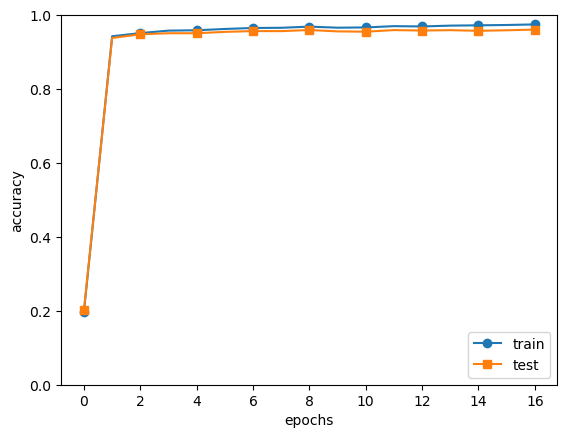

In [113]:
### 훈련하고 그래프를 출력하는 코드

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# MultiLayerNetTrainer 클래스 초기화
trainer = MultiLayerNetTrainer(input_size=784, hidden_size=15, output_size=10, iters_num=10000, batch_size=100, learning_rate=0.019, use_batchnorm=True)

# 훈련 시작
trainer.train(x_train, t_train, x_test, t_test)

# 학습 진행 상황을 그래프로 출력
markers = {"train": "o", "test": "s"}
x = np.arange(len(trainer.train_acc_list))
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [112]:
# 아래는 파라미터 최적값을 찾을때 사용했던 코드입니다.

'''
import random

# 하이퍼파라미터 범위 설정
hidden_size_range = list(range(15, 16))  # 5부터 15까지
learning_rate_range = [i * 0.001 for i in range(1, 20)]  # 0.001부터 0.019까지

# 최적의 하이퍼파라미터와 그 때의 정확도를 저장할 변수
best_params = {}
best_accuracy = 0

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 각 하이퍼파라미터 조합에 대해 모델 훈련
for hidden_size in hidden_size_range:
    for learning_rate in learning_rate_range:
        print(f"Training with hidden_size={hidden_size}, learning_rate={learning_rate}")

        # ThreeLayerNetTrainer 클래스 초기화
        trainer = MultiLayerNetTrainer(input_size=784, hidden_size=hidden_size, output_size=10, iters_num=10000, batch_size=100, learning_rate=learning_rate, use_batchnorm=True)

        # 훈련 시작
        trainer.train(x_train, t_train, x_test, t_test)

        # 테스트 정확도 계산
        test_accuracy = trainer.network.accuracy(x_test, t_test)
        print(f"Test accuracy: {test_accuracy}")

        # 현재의 하이퍼파라미터가 더 좋은 결과를 내면 저장
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_params['hidden_size'] = hidden_size
            best_params['learning_rate'] = learning_rate

print(f"Best hyperparameters are hidden_size={best_params['hidden_size']}, learning_rate={best_params['learning_rate']} with test accuracy: {best_accuracy}")
'''


'\nimport random\n\n# 하이퍼파라미터 범위 설정\nhidden_size_range = list(range(15, 16))  # 5부터 15까지\nlearning_rate_range = [i * 0.001 for i in range(1, 20)]  # 0.001부터 0.019까지\n\n# 최적의 하이퍼파라미터와 그 때의 정확도를 저장할 변수\nbest_params = {}\nbest_accuracy = 0\n\n# 데이터 읽기\n(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)\n\n# 각 하이퍼파라미터 조합에 대해 모델 훈련\nfor hidden_size in hidden_size_range:\n    for learning_rate in learning_rate_range:\n        print(f"Training with hidden_size={hidden_size}, learning_rate={learning_rate}")\n\n        # ThreeLayerNetTrainer 클래스 초기화\n        trainer = MultiLayerNetTrainer(input_size=784, hidden_size=hidden_size, output_size=10, iters_num=10000, batch_size=100, learning_rate=learning_rate, use_batchnorm=True)\n\n        # 훈련 시작\n        trainer.train(x_train, t_train, x_test, t_test)\n\n        # 테스트 정확도 계산\n        test_accuracy = trainer.network.accuracy(x_test, t_test)\n        print(f"Test accuracy: {test_accuracy}")\n\n        # 현재의 하이퍼파라미